In [39]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from matplotlib import pyplot
%matplotlib inline  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries

In [40]:
carss = pd.read_csv("monthly-mean-temp.csv")
carss.head()


,Month,Temperature
0,1920-01,40.6
1,1920-02,40.8
2,1920-03,44.4
3,1920-04,46.7
4,1920-05,54.1


In [41]:
scaler = MinMaxScaler()
scaler.fit(carss[['Temperature']])
carss['Temperature'] = scaler.transform(carss[['Temperature']])

In [42]:
cars = TimeSeries.from_dataframe(carss, "Month", "Temperature")
print(cars)

<TimeSeries (DataArray) (Month: 240, component: 1, sample: 1)>
array([[[0.26420455]],

       [[0.26988636]],

       [[0.37215909]],

       [[0.4375    ]],

       [[0.64772727]],

       [[0.77272727]],

       [[0.75      ]],

       [[0.71306818]],

       [[0.65340909]],

       [[0.54545455]],

...

       [[0.31534091]],

       [[0.46875   ]],

       [[0.59943182]],

       [[0.75852273]],

       [[0.83522727]],

       [[0.86647727]],

       [[0.76420455]],

       [[0.4375    ]],

       [[0.43465909]],

       [[0.18465909]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1920-01-01 1920-02-01 ... 1939-12-01
  * component  (component) object 'Temperature'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


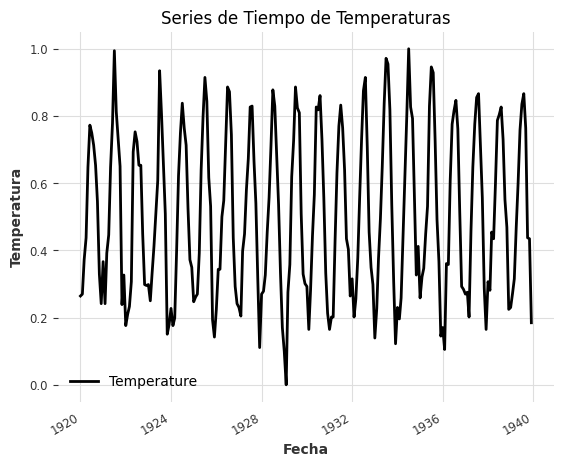

In [43]:
fig, ax = plt.subplots()
cars.plot(ax=ax)

ax.set_title("Series de Tiempo de Temperaturas")
ax.set_xlabel("Fecha")
ax.set_ylabel("Temperatura")
plt.show()

En esta serie de Tiempo, de tiene estacionalidad. En los años, se ve que la temperuatra queda más o menos la misma, sin embargo, se ve las estaciones, donde en ciertos meses de los añaos, es más caliente y frió respectivo, mostrando respectivamente las diferentes estaciones del año. 

In [44]:
from darts.models import MovingAverageFilter, NaiveMean
from darts.metrics import rmse, mae, mape
from darts.models import NaiveMovingAverage, NaiveMean
from darts.metrics import rmse, mae, mape
window_size = 12  # Adjust the window size as needed
moving_avg = MovingAverageFilter(window=window_size)
carros = moving_avg.filter(cars)


In [45]:
rmse_score = rmse(cars, carros)
mae_score = mae(cars, carros)
print(f'RMSE: {rmse_score:.2f}')
print(f'MAE: {mae_score:.2f}')

RMSE: 0.24
MAE: 0.21


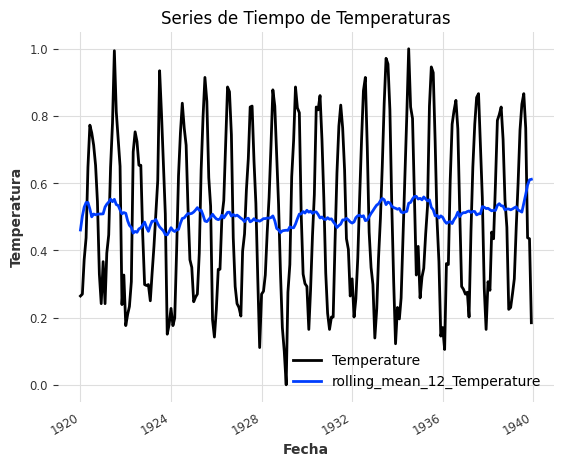

In [46]:
fig, ax = plt.subplots()
cars.plot(ax=ax)
carros.plot(ax=ax)

ax.set_title("Series de Tiempo de Temperaturas")
ax.set_xlabel("Fecha")
ax.set_ylabel("Temperatura")
plt.show()

In [47]:
# Convert the "Year-Month" column to datetime format
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
carss['Month'] = pd.to_datetime(carss['Month'])

# Set the "Year-Month" column as the DataFrame index
carss.set_index('Month', inplace=True)
train_size = int(len(carss) * 0.8)
train_data, test_data = carss[:train_size], carss[train_size:]

In [48]:
p, d, q = 1, 1, 1  # Non-seasonal components
P, D, Q, s = 1, 1, 1, 12  # Seasonal components (assuming monthly data)

sarima_model = sm.tsa.SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_results = sarima_model.fit()
predictions = sarima_results.get_forecast(steps=len(test_data))
predicted_mean = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

c:\Users\rober\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\rober\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


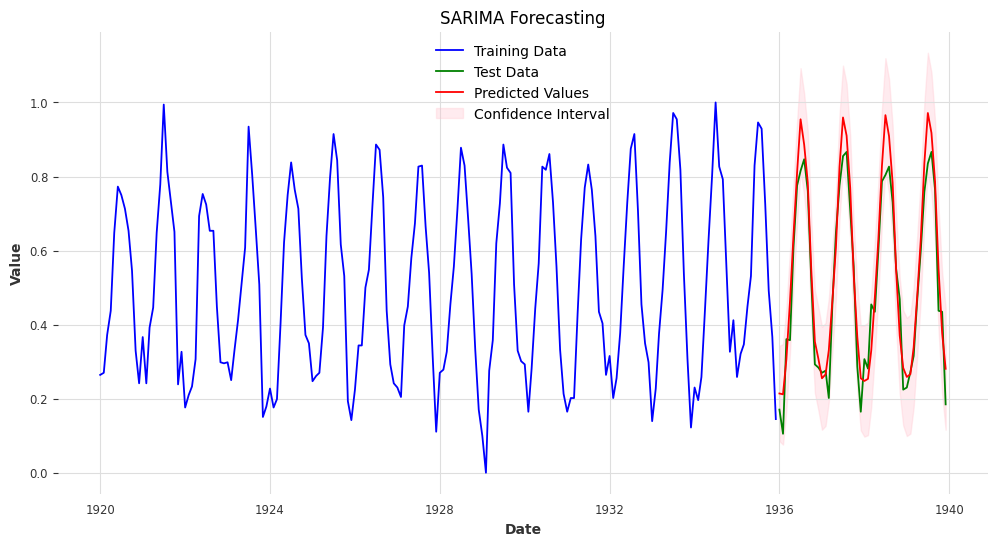

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data', color='blue')
plt.plot(test_data, label='Test Data', color='green')
plt.plot(predicted_mean, label='Predicted Values', color='red')
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.title('SARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predicted_mean))

# Calculate MAE
mae = mean_absolute_error(test_data, predicted_mean)
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

RMSE: 0.07
MAE: 0.06


<TimeSeries (DataArray) (Month: 48, component: 1, sample: 1)>
array([[[0.26686299]],

       [[0.25097577]],

       [[0.33278503]],

       [[0.45399636]],

       [[0.63071124]],

       [[0.78526033]],

       [[0.90884586]],

       [[0.85390114]],

       [[0.73770773]],

       [[0.54617138]],

...

       [[0.33769395]],

       [[0.45890527]],

       [[0.63562015]],

       [[0.79016925]],

       [[0.91375477]],

       [[0.85881005]],

       [[0.74261665]],

       [[0.55108029]],

       [[0.3423977 ]],

       [[0.2723463 ]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1936-01-01 1936-02-01 ... 1939-12-01
  * component  (component) object 'Temperature'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


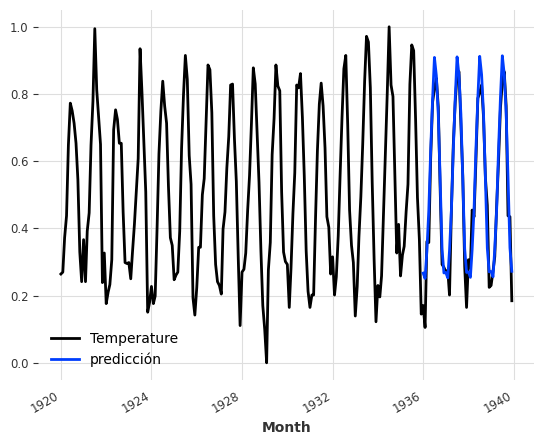

In [51]:
from darts.models import ExponentialSmoothing
train_size = int(len(cars) * 0.8)
train, test = cars[:train_size], cars[train_size:]
entreno, validacion = cars[:train_size], cars[train_size:]
model = ExponentialSmoothing()
model.fit(train)
cars.plot()
predictions = model.predict(len(test))
predictions.plot(label = "predicción")
plt.legend()
print(predictions)


In [52]:
from darts.metrics import rmse, mae
rmse_score = rmse(test, predictions)
mae_score = mae(test, predictions)
print(f'RMSE: {rmse_score:.2f}')
print(f'MAE: {mae_score:.2f}')

RMSE: 0.06
MAE: 0.05


18:05:07 - cmdstanpy - INFO - Chain [1] start processing
18:05:07 - cmdstanpy - INFO - Chain [1] done processing


<TimeSeries (DataArray) (Month: 48, component: 1, sample: 1)>
array([[[0.29283926]],

       [[0.27054954]],

       [[0.34433726]],

       [[0.4594399 ]],

       [[0.65686663]],

       [[0.798824  ]],

       [[0.89719693]],

       [[0.84503193]],

       [[0.73963909]],

       [[0.5580749 ]],

...

       [[0.3460306 ]],

       [[0.4740902 ]],

       [[0.63075971]],

       [[0.79875385]],

       [[0.94838403]],

       [[0.89078546]],

       [[0.76445842]],

       [[0.5636653 ]],

       [[0.35970179]],

       [[0.26633827]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1936-01-01 1936-02-01 ... 1939-12-01
  * component  (component) object 'Temperature'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


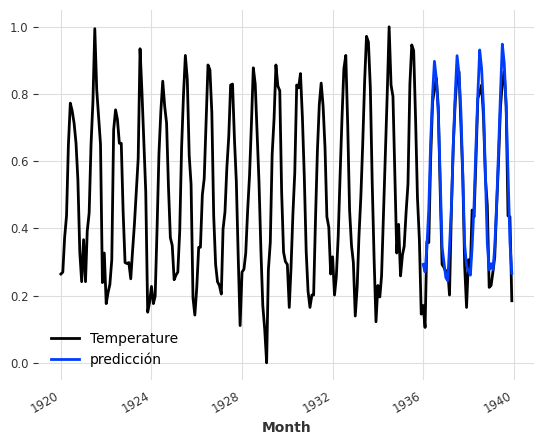

In [53]:
from darts.models.forecasting.prophet_model import Prophet
model = Prophet()
train_size = int(len(cars) * 0.8)
train, test = cars[:train_size], cars[train_size:]
entreno, validacion = cars[:train_size], cars[train_size:]
model.fit(train)
cars.plot()
predictions = model.predict(len(test))
predictions.plot(label = "predicción")
plt.legend()
print(predictions)

In [54]:
from darts.metrics import rmse, mae
rmse_score = rmse(test, predictions)
mae_score = mae(test, predictions)
print(f'RMSE: {rmse_score:.2f}')
print(f'MAE: {mae_score:.2f}')

RMSE: 0.07
MAE: 0.05


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | V             | Linear           | 26    
---------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=75` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<TimeSeries (DataArray) (Month: 48, component: 1, sample: 1)>
array([[[0.14722809]],

       [[0.16482844]],

       [[0.26270924]],

       [[0.40042291]],

       [[0.57119196]],

       [[0.71048358]],

       [[0.82559511]],

       [[0.79349657]],

       [[0.68203793]],

       [[0.50595959]],

...

       [[0.29430488]],

       [[0.4251001 ]],

       [[0.58618701]],

       [[0.72796474]],

       [[0.83007337]],

       [[0.78356979]],

       [[0.66676326]],

       [[0.47883466]],

       [[0.28864476]],

       [[0.24395031]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1936-01-01 1936-02-01 ... 1939-12-01
  * component  (component) object 'Temperature'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


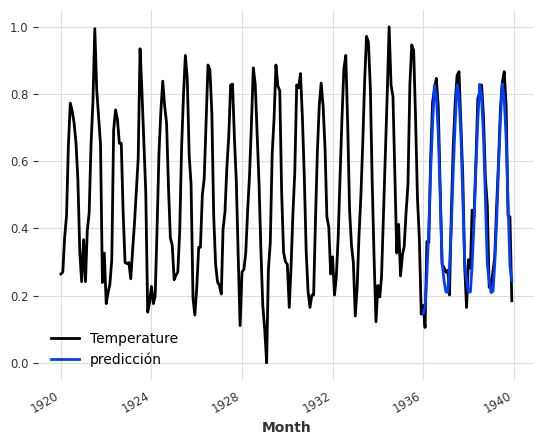

In [55]:
from darts.models import RNNModel
train_size = int(len(cars) * 0.8)
train, test = cars[:train_size], cars[train_size:]
entreno, validacion = cars[:train_size], cars[train_size:]
model = RNNModel(input_chunk_length=32, n_epochs=75, batch_size=4, random_state=2)
model.fit(train)
cars.plot()
predictions = model.predict(len(test))
predictions.plot(label = "predicción")
plt.legend()
print(predictions)

In [56]:
rmse_score = rmse(test, predictions)
mae_score = mae(test, predictions)
print(f'RMSE: {rmse_score:.2f}')
print(f'MAE: {mae_score:.2f}')

RMSE: 0.07
MAE: 0.05


Para la temperatura mensual, el mejor modelo de datos es principalmente el Prophet. Para este, se tiene el mejor RMSE y MAE combinado con siendo 0.06 y 0.05 respectivamente. Pero a excepción de medias, todos son buenos modleos para utilizar de cualquier forma.